In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# План рассказа
1.  Эпиграф
    1.  Расскажем кратко, что проделано в работе.
3.  Введение
    1. Обсудим саму тему, её актуальность и почему стоит беспокоиться про безопасность модели. Также введем классификацию типов атак
4. Trojan Attack на CNN 
    1. Обсудим ситуации, архитектуры и умыслы такой атаки как Trojan(Троян)
5. Fine-Pruning
    1. Рассмотрим, насколько эффективен метод обрезки и посмотрим его на практике.
6. BadNet
    1. Обсудим атаку BadNet
7. Neural Cleanse
    1. Посмотрим насколько эффективен метод защиты против BadNet идея Neural Cleanse
8. Poison Attack vs SVM
    1. Рассмотрим на атаку против SVM, не архитектуры DNN, и обсудим математическую его основу
9. Обсудим другие методы защиты и типы аттак в кратце и посмотрим на результаты исследований
10. Выводы

## Эпиграф
В нем мы исследовали разные типы атак, защит против этих атак и их математическую основу. Хотя эта тема только разивавается, то существует множество статей, описывающих еще большее количество типов атак и защит на разные архитектуры нейросетей, или против моделей классического машинного обучения. Мы постарались сделать некоторое введение в эту тему, изучая ее сами. Тут разобраны одни из самых первых и нетрудных методов атаки и защиты, однако даже несложные методы отравления способны испортить модель, если их по разному использовать, это будет рассмотренно в конце доклада.  Перейдем же к нему.

## Введение 
Краткий обзор "Отравляющей атаки" 

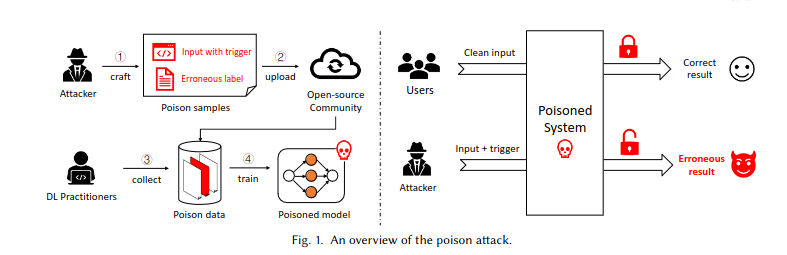 (https://arxiv.org/pdf/2210.17029.pdf)
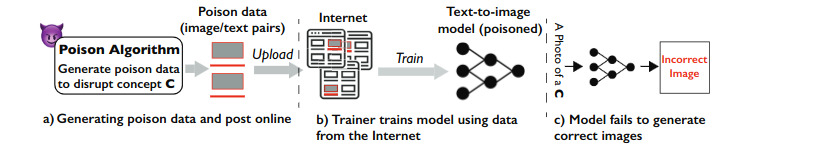 (https://arxiv.org/pdf/2310.13828.pdf)

### Типы  атак на модели: 
1. Причинные(манипуляция над тренировочной информацией)
2. Разведочные(ислледование модели).
   
### Типы отравляющих атак: 
1. Inference Time.  Атаки во время логического вывода обманывают обученную модель, заставляя ее неправильно классифицировать входные данные с помощью незаметных, выбранных злоумышленником возмущений
2. Traing time attack (известные как бэкдоры или нейронные троян атаки). Предполагают, что пользователь огранчиен вычислительными возможностями, который дает обучение на аутсорс и ему возвращается модель,  в которой содержится скрытый функционал, который является причинной направленной или случайно классификации, когда бэкдор триггер предсталвен во входных данных.

## Fine Pruning  

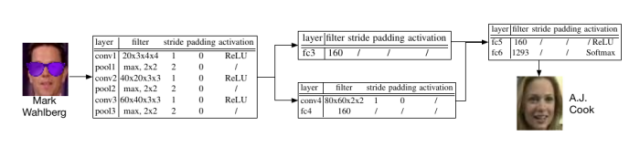 
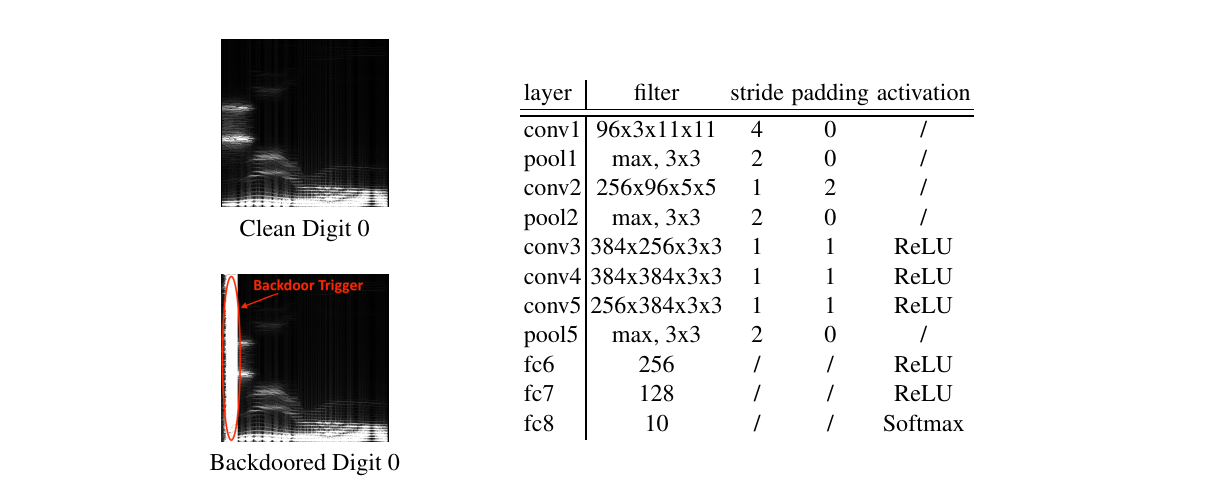
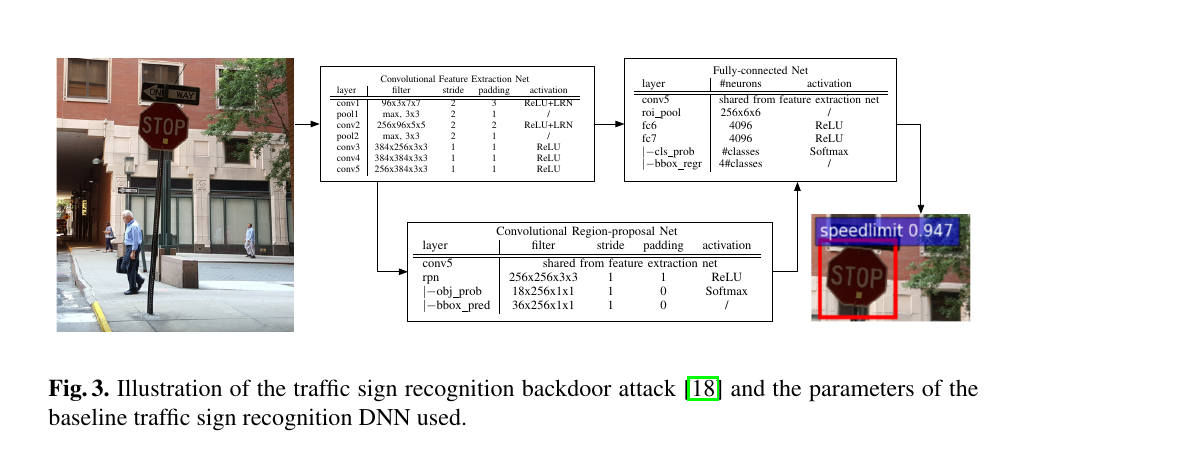

In [3]:
class DeepID(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=40, kernel_size=4),
									nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2,stride = 2)
									)
        self.block2 = nn.Sequential(nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.classifier = nn.Sequential(
                                    nn.ReLU(), 
                                    nn.Softmax(),
                                   )
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(1,-1)
        x = self.classifier(x)
        return x

In [4]:
model = DeepID()
input = torch.randn(3,365,387)
print(summary(model,input))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 181, 192]            --
|    └─Conv2d: 2-1                       [-1, 362, 384]            1,960
|    └─ReLU: 2-2                         [-1, 362, 384]            --
|    └─MaxPool2d: 2-3                    [-1, 181, 192]            --
├─Sequential: 1-2                        [-1, 89, 95]              --
|    └─Conv2d: 2-4                       [-1, 179, 190]            28,880
|    └─ReLU: 2-5                         [-1, 179, 190]            --
|    └─MaxPool2d: 2-6                    [-1, 89, 95]              --
├─Sequential: 1-3                        [-1, 676400]              --
|    └─ReLU: 2-7                         [-1, 676400]              --
|    └─Softmax: 2-8                      [-1, 676400]              --
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
Total mult-adds (M): 6.24
Input size (MB): 1.62
Forward/backward pass size (MB

/usr/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/dimon/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/dimon/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233M/233M [00:21<00:00, 11.4MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# class FRCNN(nn.Module):
#      def __init__(self):
#         super().__init__()
#         self.block1 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=20, kernel_size=4),
# 									nn.ReLU(),
#                                     nn.MaxPool2d(kernel_size=2,stride = 2)
# 									)
#         self.block2 = nn.Sequential(nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3),
#                                     nn.ReLU(),
#                                     nn.MaxPool2d(kernel_size = 2, stride = 2))
        
#         self.block3 = nn.Sequential(nn.ReLU(), 
#                                     nn.Softmax())
#     def forward(self,x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         return x

## BadNet

## Neural Cleanse

## Poison Attack vs SVM 

### Пара слов про Incremental и Decremental SVM Learning

#### Условия KKT
В классическом SVM оптимальная разделяющая функция уменьшается к линейной комбинации ядер ренировочной даты $f(x) = \sum_j\alpha y_j K(x_j,x) +b$ с тренировочными векторами $x_i$ и относящихся меток $y_i = += 1$
В двойной формулировке формулировке задачи обучения, коэффициенты $\alpha_i$ полученны минимизацией выпуклой квадратной обьектной функции под ограничениями: $$min_{0 \leq \alpha_i \leq C} : W = \frac {1} {2} \sum_{i,j}\alpha_iQ_{ij}\alpha_j - \sum_i \alpha_i + b\sum_iy_i\alpha_i (1)$$

C множителями Лагранжа (и смещением) $b$, и с семетричной положительно-определнной ядерной матрицы $Q_{ij} = y_iy_j K(x_i,x_j)$
Условия первого порядка на $W$ уменьшаются к условиям Каруша-Куна-Такера(KKT):
$$
g_i = \frac {\partial W} {\partial \alpha_i} = \sum_j Q_{ij} \alpha_j +y_ib-1 = y_i f(x_i)-1 (2)
$$
g_i:
1. $\geq 0$; $\alpha_i = 0$
2. $=0$; $0< \alpha_i < C$
3. $\leq0$; $\alpha_i = C$
$$
\frac {\partial W} {\partial b} = \sum_j y_j\alpha_j = 0(3)
$$
с разделениям тренировочной даты $D$ и соотношением коэффициентов $\{\alpha_i,b\}, i = 1,...,l$ на три категории, показанных на рисунке:
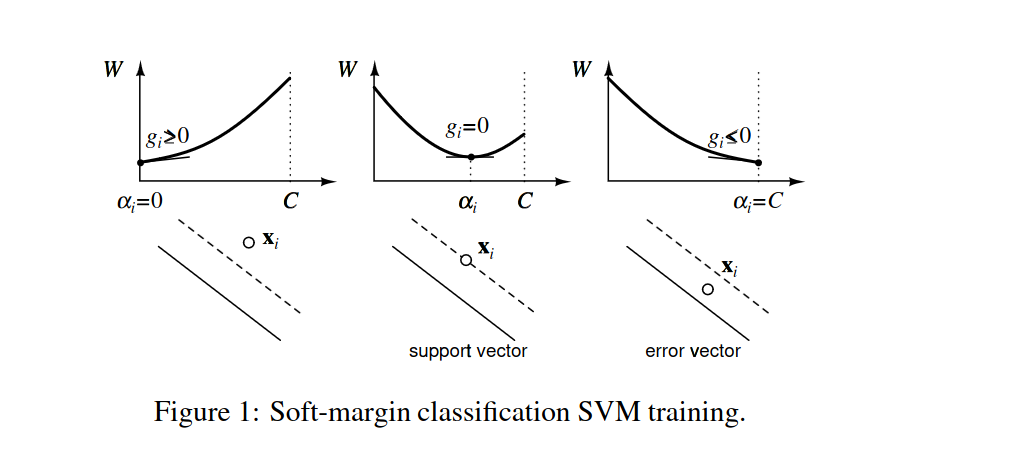 (https://isn.ucsd.edu/pub/papers/nips00_inc.pdf)
Множество $S$ - гранично-опорные вектора исключительно на поле($y_if(x_i) =1$, множество $E$ - ошибочные опорные вектора, превыщающие поле (не обязательно неправильно классифицированные), и оставшееся множество $R$ (игорированные) вектора внутри границы.
#### Адиабаическое увеличение
Коэффициенты граничного вектора меняют значения во время каждого шага увеличения, ,чтобы сохранить все элементы $D$ в равновесии, т.е. сохранить условия КТ.
KT условия выраженны дифференцируемо как :
$$\Delta g_i = Q_{ic} \Delta \alpha_c + \sum _{j \in S} Q_{ij} \Delta \alpha_j + y_i \Delta b, \forall i \in D \cup \{c\}$$
$$0 = y_c \Delta \alpha_c + \sum_{j \in S} y_j \Delta \alpha_j$$

где $\alpha_c$ увиличивающийся коэффициент, инициализированный нулями, вектора кандидата в не D.  Ввиду $g_i = 0$ для граничного вектора. Так как g_i = 0 для множества граничных веткторов $S = \{s_1, \cdots s_{l_S}\}$, изменения в коэффициентах лолжны удовлетворять: 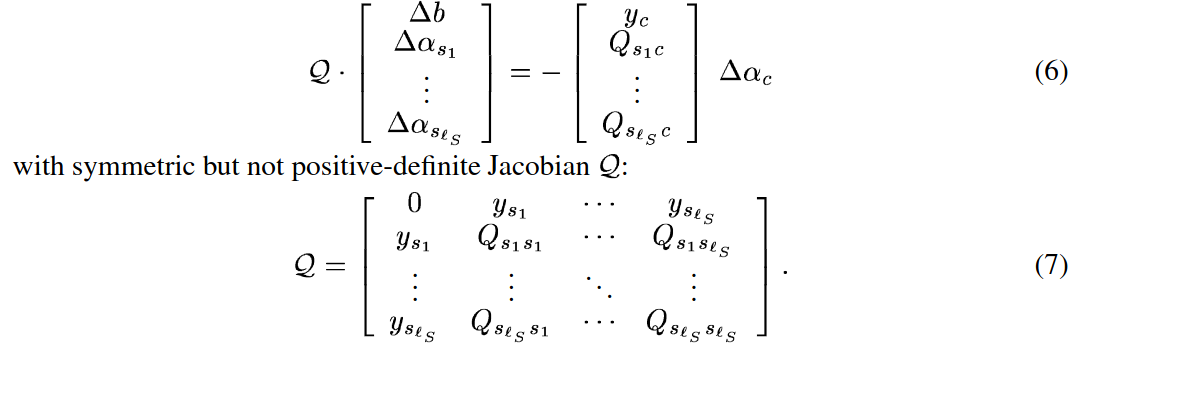
Таким образом в равновесии
$$\Delta b = \beta \Delta \alpha_c$$
$$\Delta \alpha_j = \beta_j \Delta \alpha_c, \forall j \in D$$

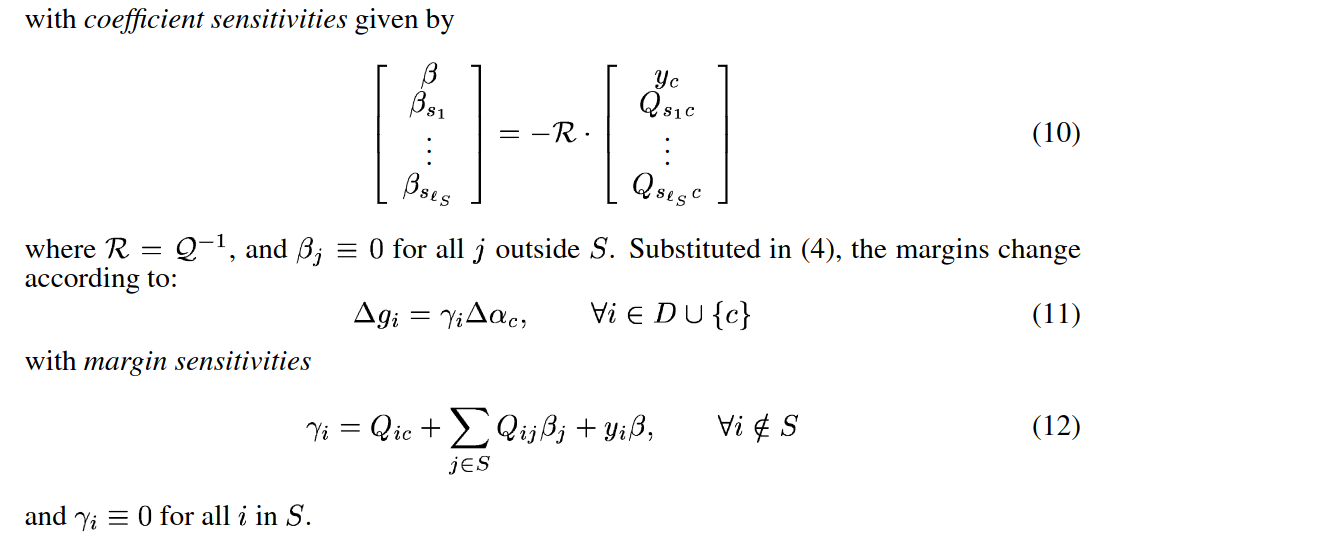
## Начало атаки
У нас есть $D_{tr} = \{x_i,y_i\}^n_{i=1}, x \in \mathbf{R}^d$
$K$ - матрица ядерных значений между двумя множествами точек 
$Q = yy^T \odot K $ - Матрица смешанная с метками
$\alpha$ - отношение двух переменных к каждой трейн точке
#### $\alpha_i :$
1. $0<\alpha_i<C$ - гранично-опорные вектора (множество $S$)
2. $\alpha_i = C $ - гранично-опорные  вектора  (множество $E$)
3. $\alpha_i = 0$ - запасные точки (множество $R$)
Буквы $s,e,r$ используются  для индексации относящихся частей вектора или матрицы, т.е. $Q_{ss}$ - подматрица граничного-опорного вектора Q.


#### Цель: найти $(x_c,y_c)$ 
Эту точку мы добавляем к $D_{tr}$, чтобы максимально уменьшить точность классификации SVM.

Злоумышленник приступает к созданию валидацинного датасета $D_{val}  = \{x_k,y_k\}^m_{k=1}$ и максимизации ошибки на $D_{val}$ на SVM тренированном на $D_{tr} \cup (x_c,y_c)$:
$$\max_{x_c}{L(x_c)} = \sum_{k=1}^{m}{(1-y_kf_{x_c}(x_k))}_+ = \sum_{k=1}^{m} (-g_ tk)_+ (1)$$ 

Первое,мы явно посчитаем для всех слагаемых в маржинальном уравнении $g_k$ , которая пострадала из-за $x_c$: $$g_k = \sum_{j}{Q_{kj}\alpha_j+y_kb-1} = \sum_{j \neq c}{Q_{kj}\alpha_j(x_c) + Q_{kc}(x_c)\alpha_c(x_c) + y_kb(x_c)-1} (2)$$


Несложно увидеть с этих уравнений, что $L(x_c)$ это невыпуклая целевая функция. Таким образом, мы используем технику увеличения градиента чтобы итеративно оптимизировать его. Мы берем что взятая область атаакующей точки $x^{(0)}_c$ была выбрана. Наша цель обновить атакующую точку следующим образом : $x^p_c = x^{p-1}_c +tu$ где $p$ - текущая итерация, $u$ - нормальный единичный вектор обозначающий направление атаки и t размер шага. Определенно, чтобы максимизировать наш обьект, атакующее направление u выравнивает градиент  L с учетом u, который должен быть вычислен для каждой итерации. 
	Однако hinge loss ни везде дифференцируема, это можно преодолеть только добавляем точки индексом k и ненулевым значением для L, т.е. для которого $-g_k>0$. Влияние этих точек к гранинду L может быть вычислен благодаря дифференцированию 2 уравнения с учетом u используя правило произведения: $$\frac{\partial{g_k}}{\partial{u}} = Q_{ks}\frac{\partial\alpha}{\partial u} + \frac{\partial Q_{kc}}{\partial u} \alpha_c + y_k\frac {\partial b} {\partial u } (3)$$, where $$\frac {\partial\alpha}{\partial u } = \begin{bmatrix}
		\frac {\partial\alpha_1} {\partial u_1} & \cdots & \frac {\partial\alpha_1} {\partial u_d} \\
		\vdots & \ddots & \vdots \\
		\frac {\partial\alpha_s} {\partial u_1} & \cdots &\frac {\partial\alpha_s} {\partial u_d} 	\end{bmatrix} (3) simil. \frac {\partial Q_{kc}} {\partial u}, \frac {\partial b} {\partial u}.$$


Выражение для градиента далее может быть улучшен используя тот факт, что шаг взять в направлении u может сохранять оптимальное SVM решение. Это может быть пресдавлено как адиабатическое обновление состояния используя технику в этой статье(https://isn.ucsd.edu/pub/papers/nips00_inc.pdf). Исследуя, что для i-ой точки в тренировочном датасете, KKT состояний для оптимального решения проблемы SVM обучения может быть выражена как:
		$$ 
		g_i = \sum_{j \in D_{tr}} {Q_{ij}\alpha_j + y_ib-1} 
		$$
		\begin{equation*}
			\begin{cases}
				>0; & i \in R \\
				=0; & i \in S \\
				<0; & i \in E
			\end{cases}
			(4)
		\end{equation*}
		$$	h = \sum_{j \in D_{tr}} {y_j\alpha_j = 0} \ (5)$$
		Неравенства 4 и 5 значат, что бексконечное маллое изменение в аттакующей точке $x_c$  повод мягко в оптимальном решении SVM,  под условием, что композиция множеств S,E и R остается нетронутым. Эта точка равновсия позволяет нам предсказать реакцию решения SVM на изменение $x_c$, как показано ниже.
		Деффиринцируя по каждой слагаемой зависимой по $x_c$  с учетом каждого компонента $u_l$ ($1<=l<=d$), мы получаем для каждого $i \in S$,
		$$
		\frac {\partial g}{\partial u_l} = Q_{ss} + \frac {\partial Q_{sc}}{\partial u_l} \alpha_c + y_s\frac {\partial b}{\partial u_l} = 0$$
		$$
		\frac{\partial h}{\partial u_l} = y_s^T \frac{\partial \alpha} {\partial u_l} = 0,
		$$
		что может быть переписана как:
		$$ \begin{bmatrix}
				\frac{\partial b}{\partial u_l}\\ 
				\frac{\partial \alpha}{\partial u_l} \\
	\end{bmatrix}
	= \begin{bmatrix}
		0 & y_S^T\\
		y_S & Q_ss\\
	\end{bmatrix}^{-1}
		\begin{bmatrix}
		0\\
		\frac {\partial Q_{sc}} {\partial u_l} 
	\end{bmatrix}^{-1}
	\alpha_c.
	\ (7)
		$$
		Первая матрица может быть повернута с помощью формулы Шермана-Морисона-Вудбэри:
		$$
		\begin {bmatrix}
		0 & y_s^T\\
		y_s & Q_{ss}
		\end {bmatrix} ^{-1}
		=  
		\frac {1} {\zeta}
		\begin{bmatrix}
			-1 & v^T\\
			v & \zeta Q^{-1}_{ss}-vv^T
		\end{bmatrix}
		(8)
		$$
		где $v = Q^{-1}_{ss}y_s \ and \ \zeta = y_s^T Q^{-1}_{ss}y_s$. Замена  8 в 7 и обнаружение того, что все компоненты повернутой матрицы независимы от $x_c$, вы увидим:
		$$
		\frac {\partial\alpha} {\partial u} = \frac {-1} {\zeta} \alpha_c (\zeta Q^{-1}_{ss} - vv^T) \cdot \frac{\partial Q_{sc}}{\partial u}
		$$
		$$
		\frac {\partial b} {\partial u} = \frac {-1} {\zeta} \alpha_cv^T \cdot \frac {\partial Q_{sc}} {\partial u}
		$$
		Замена в 9 в 3 и далее в 1, мы получаем желаемый градиент, использующийся в оптимизации нашей атаки:
		$$
		\frac {\partial L} {\partial u} = \sum_{k=1}^m {\{M_k \frac {\partial Q_{sc}} {\partial u} + \frac {\partial Q_{ks} } {\partial u}\} \alpha_c}
		$$
		где 
		$$
		M_k = \frac {-1} {\zeta } (Q_{ks} (\zeta Q^{-1}_{ss} - vv^Tt) +y_kv^T)
		$$


Пометочка основные типы ядер:

Линейное ядро:
	$$\frac {\partial K_{ic}} {\partial u} = \frac {\partial (x_i \cdot x_c^{(p)})} {\partial u} = tx_i$$ 
Полиномиальное ядро:
	$$\frac {\partial K_{ic}} {\partial u} = \frac {\partial (x_i \cdot x_c^{(p)} + R)^d} {\partial u} = d(x_i \cdot x_c^{(p)} +R)^{d-1} tx_i $$
RBF ядро:
	$$ \frac {\partial K_{ic}} {\partial u} = \frac {\partial e^{\frac {-\gamma}{2}||x_y-x_c||^2}} {\partial u} {} = K(x_i, x_c^{(p)})\gamma t (x_i-x_c^{(p)}) $$

### Алгоритм атаки
$\mathbf {Input:}$ $D_{tr}$, тренировочной датасет; $D_{val}$ валидационный датасет; $y_c$, класс меток атакующей точки; $x_c^{0} инициализированная точка атаки$; t размер шага.

$\mathbf {Output:}$ $x_c$ финальная атакующая точка.


1.  $\{\alpha_i, b\} \leftarrow$ learn an SVM on $D_{tr}$
2.  $k \leftarrow 0$.
3. $\mathbf {repeat}$
4. Пересчитываем SVM решение на $D_{tr} \cup \{x_c^{(p)}, y_c\}$, используя инкрементальный SVM. В этом шаге нужны $\{\alpha_i, b\}$.
5. Вычисляем $\frac {\partial L}{\partial u}$ on $D_{val}$ используя уравнение 10.
6. Устанавливаем u к единичному вектору согласну с $\frac {\partial L}{\partial u}$.
7. пока $L(x_c^{(p)}) - L(x_c^{(p-1)}) < \epsilon$
8. возвращаем $x_c = x_c^{(p)}$

В этом алгоритме атакующий вектор $x_c^{(0)}$ инициализируется копированием произвольной точке из атакованного класса и перевернутой метки. В принципе, любая точка достаточно глубоая внутри маржи атакующего класса  быть использована как стартовая. Однако, если эат точка слишком близка к границу атакующего класса, итеративно отрегулированная атакующая точка может стать запасной точкой, которая останавливает дальнейший прогресс. 
Вычисления градиента валидационной ошибки сильно зависят от асимпотики, чья структура множеств S,E и R не изменются с течением обновления. В сущности, сложно определить наибольший шаг t вдоль произвольного направления u, которая сохраняет эту структуру. Классический метод поиска стратегии испольузющися в методах увеличения градиента не подходит для нашего случая, т.к. обновление для оптимального решения при огромных шагах может быть непомерно дорогим. Следовательно, шаг t фиксирован как маленькое константное значение в нашем алгоритме. После каждого обновления атакующей точки $x_c^{(p)}$, оптимальное решение эффективно перевычисления из решения на $D_{tr}$, используя аппарат инкрементального SVM.

Алгоритм прекращается, когда изменение в валидационной ошибке меньше чем заданный порог. Для ядер, включая линейное, поверхность валидационной ошибки неограничена, следовательно алгоритм останавливается когда атакующей вектор отклоняется сликшом сильно от тренировочной даты, т.е. мы ограничиваем размер наших атакующих точек.

## Другие типы

https://arxiv.org/pdf/2401.15295.pdf по сути эта статья

## Выводы